In [1]:
import argparse
import midi
import os

from constants import *
from dataset import load_all
from generate import write_file, generate
from play_music_util import play_music

import pygame
import base64

# from playsound import playsound
import numpy as np
import copy 

import math
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
%matplotlib inline

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch

/opt/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from collections import Counter
g_tokens = [1,3,5,3,]
a_tokens = [1,3,5,]

In [5]:
Counter(g_tokens) & Counter(a_tokens)

Counter({1: 1, 3: 1, 5: 1})

In [2]:
from train_fn import train
from model import Generator, time_axis 

In [3]:
styles = [['/data/i.anokhin/music_out/data/Bach']]
print(styles[0])
print('Loading data')
X, y = load_all(styles, BATCH_SIZE, SEQ_LEN)
print(X.shape, y.shape )

X_tr = X[:-1]
X_te = X[-1:]
y_tr = y[:-1]
y_te = y[-1:]

['/data/i.anokhin/music_out/data/Bach']
Loading data
(5727, 128, 48, 3) (5727, 128, 48, 3)


In [4]:
generator = Generator()
generator.cuda()

Generator(
  (time_ax): time_axis(
    (attention_note_layer): MultiHeadAttention(
      (attention): ScaledDotProductAttention(
        (dropout): Dropout(p=0.1)
      )
      (proj): Linear(in_features=291, out_features=97, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (FF_note): PositionwiseFeedForward(
      (w_1): Linear(in_features=97, out_features=388, bias=True)
      (w_2): Linear(in_features=388, out_features=97, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (attention_time_layer): MultiHeadAttention(
      (attention): ScaledDotProductAttention(
        (dropout): Dropout(p=0.1)
      )
      (proj): Linear(in_features=256, out_features=256, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (FF_time): PositionwiseFeedForward(
      (w_1): Linear(in_features=256, out_features=1024, bias=True)
      (w_2): Linear(in_features=1024, out_features=256, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (time_lstm): LSTM(113, 256, num_layers=2, batch_first=True, 

Epoch 2 of 100 took 109.944s
current train loss: 0.08277499143492077
current val loss: 0.0620446652173996


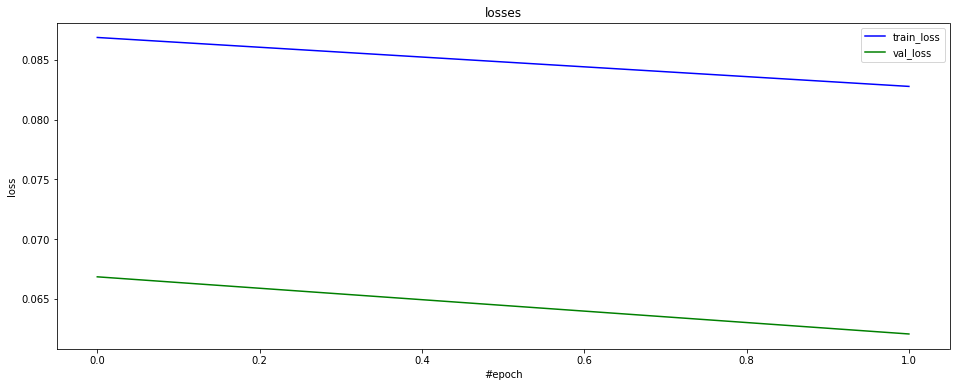

523it [01:20,  6.46it/s]

In [ ]:
generator.note_ax.to_train = True
generator.note_ax.apply_T = False
generator, epoch, epoch_history = train(generator, X_tr, X_te, y_tr, y_te, 
                                 batchsize=8, n_epochs = 100, verbose=True)

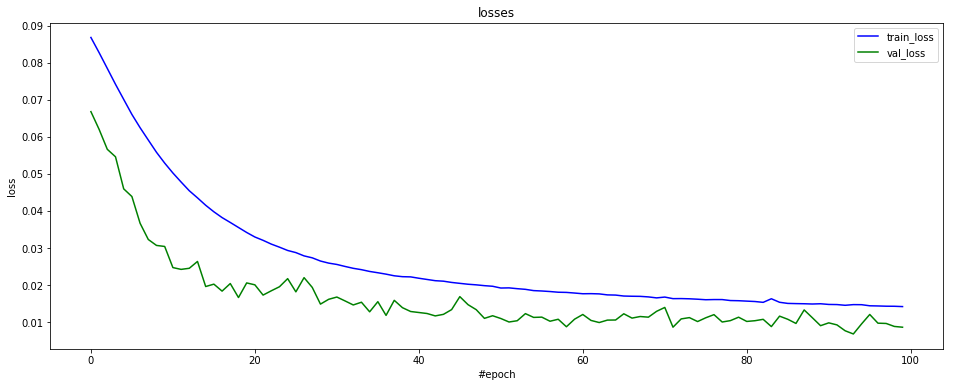

In [10]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(16, 6))

plt.title("losses")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(epoch_history['train_loss'], 'b', label = 'train_loss')
plt.plot(epoch_history['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.show()

In [2]:
epoch_history

NameError: name 'epoch_history' is not defined

In [3]:
# generator = Generator()
# generator.cuda()

## Save/load the model

In [13]:
# from model import Generator, iterate_minibatches, compute_loss, train
torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'generator'))
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_track_featured'))
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_canonical_attention'))
# the_model = Generator()
# generator = Generator()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_test3')))
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'generator3')))
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_track_featured')))


In [6]:
# def generate_sample(generator,batch_size):
#     sound = torch.zeros(batch_size,SEQ_LEN,OCTAVE*NUM_OCTAVES,3).cuda()
#     print(sound.shape)
#     generator.note_ax.to_train = False
#     time_model, note_model, track_feature_model = generator.time_ax, generator.note_ax, generator.overall_information
#     for t in range(SEQ_LEN):
#         note_features = time_model(sound.data)
#         note_features = note_features[:, -1:, :]
# #         print('note_features', note_features.shape)
#         track_features = track_feature_model(sound.data)      
#         current_sound,prob = note_model(note_features, None, track_features)
#     generator.note_ax.to_train = True
#     return prob ,current_sound

In [7]:
# generate_sample(generator, 2)

In [13]:
generator.note_ax.temperature

1

In [8]:
# print(the_model)
# for i in list(the_model.note_ax.note_lstm.parameters()):
#     print(i.shape)

# Canonical

In [8]:
generator.cuda()
generator.eval()
# generator.note_ax.to_train=False
# generator.note_ax.apply_T=False
write_file('out/samples/output/canonical_test', generate(generator, 16, to_train=True))

  0%|          | 1/256 [00:00<00:44,  5.71it/s]

Generating with no styles:


100%|██████████| 256/256 [00:26<00:00,  9.58it/s]

Writing file out/samples/output/canonical_test_0.mid


In [12]:
write_file('out/samples/output/canonical_test1', generate(generator, 48, to_train=False))

  0%|          | 2/768 [00:00<01:00, 12.62it/s]

Generating with no styles:


100%|██████████| 768/768 [00:31<00:00, 24.57it/s]


Writing file out/samples/output/canonical_test1_0.mid


In [ ]:
# midi_file = 'out/samples/output/canonical_test_0.mid'
# play_music(midi_file)